# Citibike Analysis

In [24]:
import calendar
import holidays
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import scipy
import seaborn as sns

from datetime import datetime
from plotly.subplots import make_subplots
from scipy.stats import norm
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn import preprocessing
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import make_pipeline

## Read the prepared CSV

In [25]:
df_nyc = pd.read_csv("data/nyc/nyc-daily.csv", parse_dates=["date"], index_col=0)
df_nyc.tail()

,date,count,Year,Month,Week,Day,Day of Week,Day of Year
2727,2020-11-26,31215,2020,11,48,26,3,331
2728,2020-11-27,53848,2020,11,48,27,4,332
2729,2020-11-28,53896,2020,11,48,28,5,333
2730,2020-11-29,53239,2020,11,48,29,6,334
2731,2020-11-30,23528,2020,11,49,30,0,335


In [26]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_nyc["date"],
                         y=df_nyc["count"],
                         mode='markers',
                         marker=dict(size=3, color="blue")))
fig.update_layout(
    xaxis_title="Date",
    yaxis_title="Trips",
    title_text="Citi Bike daily trips 2013-2020"
)
fig.show()

In [27]:
df = df_nyc[df_nyc["Year"] < 2020].copy()
df_year = df.groupby(["Year"]).mean().reset_index()
df_year["Year"] = df_year["Year"].astype(str)
df_month = df.groupby(["Month"]).mean().reset_index()
df_dow = df.groupby(["Day of Week"]).mean().reset_index()

fig = make_subplots(rows=1, cols=3, subplot_titles=["Year", "Month", "Day of Week"])

fig.update_layout(
    barmode='group',
    title_text="Average number of daily trips by year, month and day of week 2013-2019"
)

months = [calendar.month_abbr[i] for i in range(1,13)]
dows = [calendar.day_abbr[i] for i in range(0,7)]

fig.append_trace(go.Bar(x=df_year["Year"], y=df_year["count"], marker_color="blue", showlegend=False), row=1, col=1)
fig.append_trace(go.Bar(x=months, y=df_month["count"], marker_color="blue", showlegend=False), row=1, col=2)
fig.append_trace(go.Bar(x=dows, y=df_dow["count"], marker_color="blue", showlegend=False), row=1, col=3)

fig.update_yaxes(title_text="Average daily trips", row=1, col=1)

fig.show()

## Building a model

Create calendar features for regrssion.

In [28]:
us_holidays = holidays.US()

def add_calendar_features(df):
    df_new = df.copy()
    days_in_year = np.where(df_nyc["Year"].apply(lambda y: calendar.isleap(y)), 366, 365)
    df_new['sin_doy'] = np.sin(2*np.pi*df_new["Day of Year"]/days_in_year)
    df_new['cos_doy'] = np.cos(2*np.pi*df_new["Day of Year"]/days_in_year)
    df_new['sin_dow'] = np.sin(2*np.pi*df_new["Day of Week"]/7)
    df_new['cos_dow'] = np.cos(2*np.pi*df_new["Day of Week"]/7)
    df_new = pd.concat([df_new, pd.get_dummies(df_new["Day of Week"], "dow")], axis=1)
    df_new = pd.concat([df_new, pd.get_dummies(df_new["Month"], "month")], axis=1)
    df_new = pd.concat([df_new, pd.get_dummies(df_new["Day"], "day")], axis=1)
    df_new["holiday"] = [1 if d in us_holidays else 0 for d in df_new["date"]]
    return df_new

df_nyc = add_calendar_features(df_nyc)

In [29]:
calendar_features = ["Year", "sin_doy", "cos_doy", "sin_dow", "cos_dow", "holiday"] \
    + [f"dow_{i}" for i in range(7)] \
    + [f"month_{i+1}" for i in range(12)]

### Regression models
Define multiple regression models and select the best one.

In [30]:
def mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def fit_predict(
    df,
    features,
    model="linear",
    scale=True,
    log=False,
    train_year_to=2018,
    test_year=2019,
    degree=2,
    alphas=np.logspace(-2,2)
):
    df_train = df[df["Year"] <= train_year_to]
    df_test = df[df["Year"] == test_year]
    
    X = df_train[features]
    y = df_train["count"]
    
    if scale:
        scaler = StandardScaler()
        scaler.fit(X)
        X = scaler.transform(X)
    if log: y = np.log(y)
  
    if model == "linear":
        regr = LinearRegression()
    elif model == "polynomial":
        regr = make_pipeline(
            PolynomialFeatures(degree=degree),
            LinearRegression()
            )
    elif model == "ridge":
        regr = make_pipeline(
            PolynomialFeatures(degree=degree),
            RidgeCV(alphas=alphas, cv=TimeSeriesSplit())
            )
    else:
        assert False, f"Unknown model {model}"
        
    regr.fit(X, y)
    
    if model == "ridge":
        print(f"Best alpha: {regr['ridgecv'].alpha_}")
    
    X_test = df_test[features]
    if scale: X_test = scaler.transform(X_test) 
    y_train = regr.predict(X)
    y_test = regr.predict(X_test)
    if log: y_test, y_train = np.exp(y_test), np.exp(y_train)
    
    print(f"Training set R2 score: {r2_score(df_train['count'], y_train)}")
    print(f"Test set R2 core: {r2_score(df_test['count'], y_test)}")
    print(f"Test set MAPE: {mape(df_test['count'], y_test)}")
    
    return df_train, df_test, y_test, y_train, regr

#### Linear regression

In [31]:
df_train, df_test, y_test, y_train, regr = fit_predict(df_nyc, calendar_features, model="linear", scale=True)

Training set R2 score: 0.7557969523927286
Test set R2 core: 0.5999742339703569
Test set MAPE: 28.93432079924826


#### Model evaluation
Create plots to visualize and evaluate prediction:
- normalized residuals plot
- actual vs predicted scatterplot
- actual vs predicted interactive plot
- actual vs predicted plot by month, day of week

In [32]:
def plot_model_evaluation(df_test, y_test):
    y_true = df_test["count"]
    residuals = y_true - y_test
    fig, axs = plt.subplots(1, 2, figsize=(20,5))

    p0 = sns.histplot(residuals, ax=axs[0], stat="density")
    axs[0].set_xlabel('Residuals', fontsize=18)
    axs[0].set_ylabel('')
    p0.text(residuals.min(), p0.get_ylim()[1]*0.8, "Mean of residuals: {:.2f}".format(residuals.mean()))
    
    mean,std = norm.fit(residuals)
    x = np.linspace(residuals.min(), residuals.max(), 100)
    y = norm.pdf(x, mean, std)
    sns.lineplot(x=x, y=y, ax=axs[0])
    
    sns.scatterplot(x=y_true, y=y_test, ax=axs[1])
    axs[1].set_xlabel('Actual', fontsize=18)
    axs[1].set_ylabel('Predicted', fontsize=18)
    sns.lineplot(x=[0, max(y_true)], y=[0, max(y_true)], ax=axs[1])

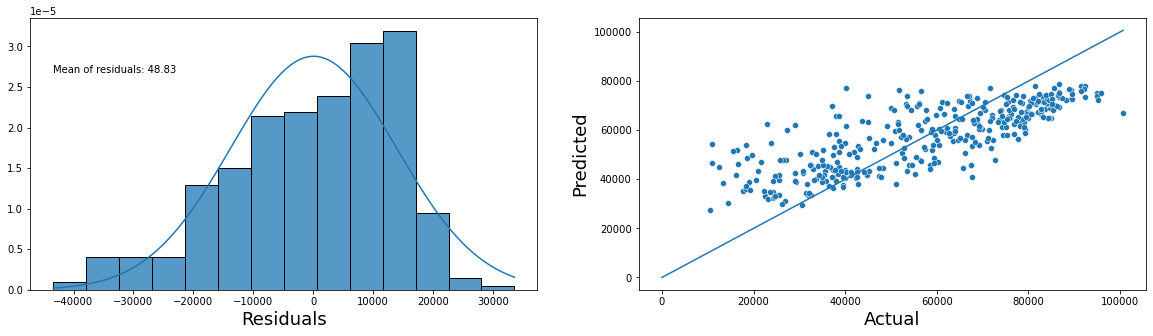

In [33]:
plot_model_evaluation(df_test, y_test)

In [34]:
def plot_dow_month(df_test,
                   y_test,
                   comparison=None,
                   comparison_title=None,
                   title=None
                  ):
    df = df_test.copy()
    df["count_pred"] = y_test
    if comparison is not None:
        df["comparison"] = comparison[:len(df.index)]
    df_test_dow = df.groupby(["Day of Week"]).mean().reset_index()
    df_test_month = df.groupby(["Month"]).mean().reset_index()
    df_test_year = df.groupby(["Year"]).mean().reset_index()
    import plotly.graph_objects as go
    from plotly.subplots import make_subplots

    fig = make_subplots(rows=1, cols=3, subplot_titles=["Month", "Day of Week", "Overall"])

    fig.update_layout(
        barmode='group',
        title_text=title
    )
    
    months = [calendar.month_abbr[i] for i in df_test_month["Month"]]
    dows = [calendar.day_abbr[i] for i in df_test_dow["Day of Week"]]

    if comparison is not None:
        fig.append_trace(go.Bar(name=comparison_title, x=months, y=df_test_month["comparison"], marker_color="#fc8d59"), row=1, col=1)
        fig.append_trace(go.Bar(name=comparison_title, x=dows, y=df_test_dow["comparison"], showlegend=False, marker_color="#fc8d59"), row=1, col=2)
        fig.append_trace(go.Bar(name=comparison_title, x=["Overall"], y=df_test_year["comparison"], showlegend=False, marker_color="#fc8d59"), row=1, col=3)

    fig.append_trace(go.Bar(name='Predicted', x=months, y=df_test_month["count_pred"], marker_color="red"), row=1, col=1)
    fig.append_trace(go.Bar(name='Predicted', x=dows, y=df_test_dow["count_pred"], showlegend=False, marker_color="red"), row=1, col=2)
    fig.append_trace(go.Bar(name='Predicted', x=["Overall"], y=df_test_year["count_pred"], showlegend=False, marker_color="red"), row=1, col=3)
        
    fig.append_trace(go.Bar(name='Actual', x=months, y=df_test_month["count"], marker_color="blue"), row=1, col=1)
    fig.append_trace(go.Bar(name='Actual', x=dows, y=df_test_dow["count"], showlegend=False, marker_color="blue"), row=1, col=2)
    fig.append_trace(go.Bar(name='Actual', x=["Overall"], y=df_test_year["count"], showlegend=False, marker_color="blue"), row=1, col=3)
    
    fig.update_yaxes(title_text="Average daily trips", row=1, col=1)
    
    fig.show()

In [35]:
plot_dow_month(df_test, y_test)

In [36]:
def plot_markers(fig, x, y, color, name):
    fig.add_trace(go.Scatter(x=x,
                             y=y,
                             mode='markers',
                             marker=dict(size=3, color=color),
                             name=name))
    
def plot_lines(fig, x, y, color, window, name):
    fig.add_trace(go.Scatter(x=x,
                             y=y,
                             mode='lines',
                             marker_color=color,
                             name=f'{name}<br>({window}-day average)'))
    

def plot_test(df_test,
              y_test,
              title=None,
              scatter=True,
              ma=True,
              comparison=None,
              comparison_title=None,
              show=True):
    fig = go.Figure()
    fig.update_layout(
        legend=dict(
            yanchor="top",
            y=0.99,
            xanchor="left",
            x=0.01
        )
    )

    df = df_test.copy()
    df["count_pred"] = y_test
    
    window = 14
    
    df['count_ma'] = df["count"].rolling(window).mean()    
    df['count_pred_ma'] = df["count_pred"].rolling(window).mean()
    
    if scatter:
        plot_markers(fig, df["date"], df["count"], "blue", "Actual")
        plot_markers(fig, df["date"], df["count_pred"], "red", "Predicted")
        
    if ma:
        plot_lines(fig, df["date"], df["count_ma"], "blue", window, "Actual")
        plot_lines(fig, df["date"], df["count_pred_ma"], "red", window, "Predicted")
    
    if comparison is not None:
        df["comparison"] = comparison[:len(df.index)]
        df["comparison_ma"] = df["comparison"].rolling(window).mean()
        if scatter: plot_markers(fig, df["date"], df["comparison"], "#fc8d59", comparison_title)
        if ma: plot_lines(fig, df["date"], df["comparison_ma"], "#fc8d59", window, comparison_title)

    fig.update_layout(
        xaxis_title="Date",
        yaxis_title="Trips",
        title_text=title
    )
    
    return fig
    
def plot_all(df_train, df_test, y_train, y_test):
    return plot_test(pd.concat([df_train, df_test]), np.append(y_train, y_test))

In [37]:
plot_test(df_test, y_test, "Actual and predicted number of trips in 2019<br>Linear regression with calendar features")

#### Polynomial regression

In [38]:
df_train, df_test, y_test, y_train, regr = fit_predict(df_nyc, calendar_features, model="polynomial", degree=2)

Training set R2 score: 0.810711495798258
Test set R2 core: 0.6490807735383909
Test set MAPE: 24.1224542531287


#### Polynomial regression with ridge regularization

In [39]:
df_train, df_test, y_test, y_train, regr = fit_predict(df_nyc, calendar_features, model="ridge", degree=2, alphas=np.logspace(1,3))

Best alpha: 95.40954763499938
Training set R2 score: 0.7990829739614943
Test set R2 core: 0.6535170353206505
Test set MAPE: 24.185788423831095


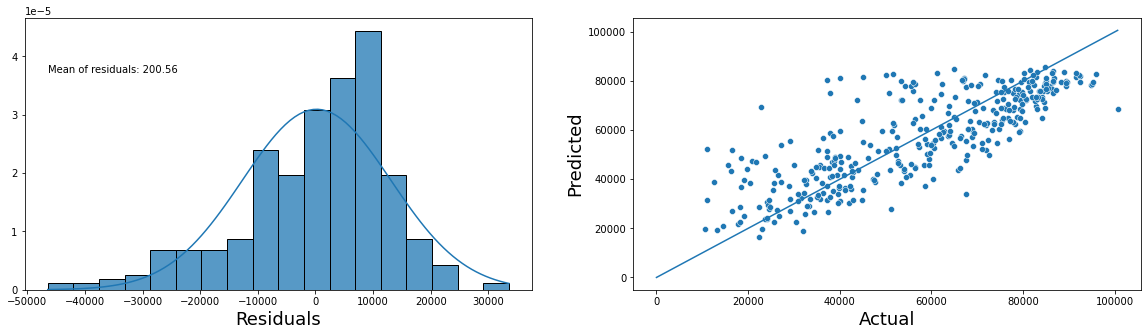

In [40]:
plot_model_evaluation(df_test, y_test)

In [41]:
plot_test(df_test,
          y_test,
          "Actual and predicted number of trips in 2019<br>Polynomial regression with regularization using calendar features")

## Adding more features

### Weather
Load weather data. Data has the following columns  
- Wind speed
    - AWND: average wind speed
    - PGTM: peak gust time (missing)
    - WDF*: direction of fastest 1, 2, 5-minute wind
    - WSF*: fastest 1, 2, 5-minute wind
- Temperature
    - TAVG: average (missing)
    - TMAX: maximum
    - TMIN: minimum
- PRCP: precipitation
- SNOW: snowfall
- SNWD: snow depth
- TSUN: sunshine hours (missing)
- Weather types:
    - WT01 - Fog ice fog or freezing fog (may include heavy fog)
    - WT02 - Heavy fog or heaving freezing fog (not always distinguished from fog)
    - WT03 - Thunder
    - WT04 - Ice pellets sleet snow pellets or small hail
    - WT06 - Glaze or rime
    - WT08 - Smoke or haze
    - WT13 - Mist
    - WT14 - Drizzle
    - WT16 - Rain (may include freezing rain drizzle and freezing drizzle)
    - WT18 - Snow snow pellets snow grains or ice crystals
    - WT19 - Unknown source of precipitation
    - WT22 - Ice fog

In [42]:
pd.set_option('display.max_columns', None)

df_nyc_weather = pd.read_csv("data/nyc/weather.csv", parse_dates=["DATE"])
# Fill NaN values with zeroes
df_nyc_weather.fillna(value="0", inplace=True)
df_nyc_weather["SNOW"] = df_nyc_weather["SNOW"].astype(int)
df_nyc_weather["AWND"] = df_nyc_weather["AWND"].astype(float)
# Drop values before 01.06.2013
df_nyc_weather = df_nyc_weather[df_nyc_weather["DATE"] >= datetime.strptime("2013-06-01", "%Y-%m-%d")]
df_nyc_weather.head()

,STATION,DATE,AWND,PGTM,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,TSUN,WDF2,WDF5,WSF2,WSF5,WT01,WT02,WT03,WT04,WT06,WT08,WT13,WT14,WT16,WT18,WT19,WT22
151,USW00094728,2013-06-01,3.80,0,0.00,0,0.0,0,90,73,0,250,260,12.1,19.9,0,0,0,0,0,0,0,0,0,0,0,0
152,USW00094728,2013-06-02,6.04,0,0.85,0,0.0,0,88,69,0,250,270,15,25.9,1,0,0,0,0,0,0,0,0,0,0,0
153,USW00094728,2013-06-03,3.36,0,0.87,0,0.0,0,78,66,0,250,250,12.1,19,1,0,0,0,0,0,0,0,0,0,0,0
154,USW00094728,2013-06-04,4.92,0,0.00,0,0.0,0,75,57,0,10,340,13,21,0,0,0,0,0,0,0,0,0,0,0,0
155,USW00094728,2013-06-05,3.80,0,0.00,0,0.0,0,74,58,0,160,210,10.1,19,0,0,0,0,0,0,0,0,0,0,0,0


PGTM, TAVG and TSUN have no data

In [43]:
weather_types = {
    "WT01": "WT01_fog",
    "WT02": "WT02_heavy_fog",
    "WT03": "WT03_thunder",
    "WT04": "WT04_ice_pellets",
    "WT06": "WT06_glaze",
    "WT08": "WT08_smoke_haze",
    "WT13": "WT13_mist",
    "WT14": "WT14_drizzle",
    "WT16": "WT16_rain",
    "WT18": "WT18_snow_pellets",
    "WT19": "WT19_unknown_precipitation",
    "WT22": "WT22_ice_fog"
}

df_nyc_weather[weather_types.keys()].rename(columns=weather_types).astype(int).sum().sort_values(ascending=False)

WT01_fog                      959
WT08_smoke_haze               482
WT03_thunder                   82
WT02_heavy_fog                 52
WT06_glaze                     14
WT04_ice_pellets                5
WT22_ice_fog                    0
WT19_unknown_precipitation      0
WT18_snow_pellets               0
WT16_rain                       0
WT14_drizzle                    0
WT13_mist                       0
dtype: int64

WT13, WT14, WT16, WT18, WT19, WT22 have no data. Only WT01 and WT08 have a signifcant amount of data points.

In [44]:
to_drop = ["PGTM", "TAVG", "TSUN"]
to_drop += ['WT13', 'WT14', 'WT16', 'WT18', 'WT19', 'WT22']
df_nyc_weather.drop(columns=to_drop, inplace=True)

In [45]:
df_nyc = pd.merge(left=df_nyc, right=df_nyc_weather.drop(["STATION"], axis=1), left_on='date', right_on='DATE')
df_nyc.tail()

,date,count,Year,Month,Week,Day,Day of Week,Day of Year,sin_doy,cos_doy,sin_dow,cos_dow,dow_0,dow_1,dow_2,dow_3,dow_4,dow_5,dow_6,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,day_1,day_2,day_3,day_4,day_5,day_6,day_7,day_8,day_9,day_10,day_11,day_12,day_13,day_14,day_15,day_16,day_17,day_18,day_19,day_20,day_21,day_22,day_23,day_24,day_25,day_26,day_27,day_28,day_29,day_30,day_31,holiday,DATE,AWND,PRCP,SNOW,SNWD,TMAX,TMIN,WDF2,WDF5,WSF2,WSF5,WT01,WT02,WT03,WT04,WT06,WT08
2727,2020-11-26,31215,2020,11,48,26,3,331,-0.565345,0.824855,0.433884,-0.900969,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,2020-11-26,4.70,0.79,0,0.0,65,55,270,270,13,19.9,1,0,0,0,0,0
2728,2020-11-27,53848,2020,11,48,27,4,332,-0.551102,0.834438,-0.433884,-0.900969,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,2020-11-27,3.36,0.00,0,0.0,63,51,290,270,8.9,14.1,0,0,0,0,0,0
2729,2020-11-28,53896,2020,11,48,28,5,333,-0.536696,0.843776,-0.974928,-0.222521,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,2020-11-28,4.92,0.00,0,0.0,56,44,280,10,14.1,21.9,0,0,0,0,0,0
2730,2020-11-29,53239,2020,11,48,29,6,334,-0.522133,0.852864,-0.781831,0.623490,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,2020-11-29,2.24,0.00,0,0.0,54,41,230,200,8.9,14.1,0,0,0,0,0,0
2731,2020-11-30,23528,2020,11,49,30,0,335,-0.507415,0.861702,0.000000,1.000000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,2020-11-30,6.26,0.98,0,0.0,63,50,170,200,19.9,35.1,1,0,0,0,0,0


#### Exploratory analysis

Plot number of trips against weather as % of yearly max.

In [46]:
year_max = df_nyc.groupby(["Year"])["count"].max()
df_nyc = pd.merge(left=df_nyc, right=year_max, left_on='Year', right_index=True, suffixes=('', 'max'))

df_nyc["count_mean"] = df_nyc["count"] / df_nyc["countmax"]

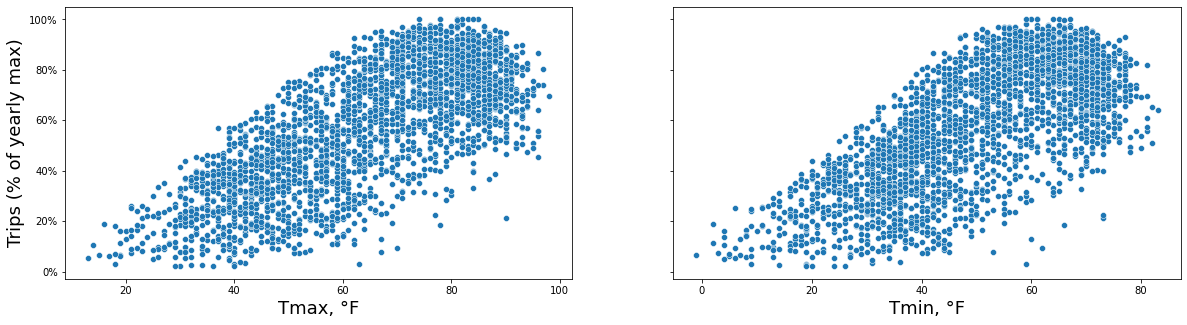

In [47]:
fig, axs = plt.subplots(1, 2, figsize=(20,5), sharey=True)

sns.scatterplot(x=df_nyc["TMAX"], y=df_nyc["count_mean"], ax=axs[0])
axs[0].set_xlabel('Tmax, °F', fontsize=18)
axs[0].set_ylabel('Trips (% of yearly max)', fontsize=18)
axs[0].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))

sns.scatterplot(x=df_nyc["TMIN"], y=df_nyc["count_mean"], ax=axs[1])
axs[1].set_xlabel('Tmin, °F', fontsize=18)
pass

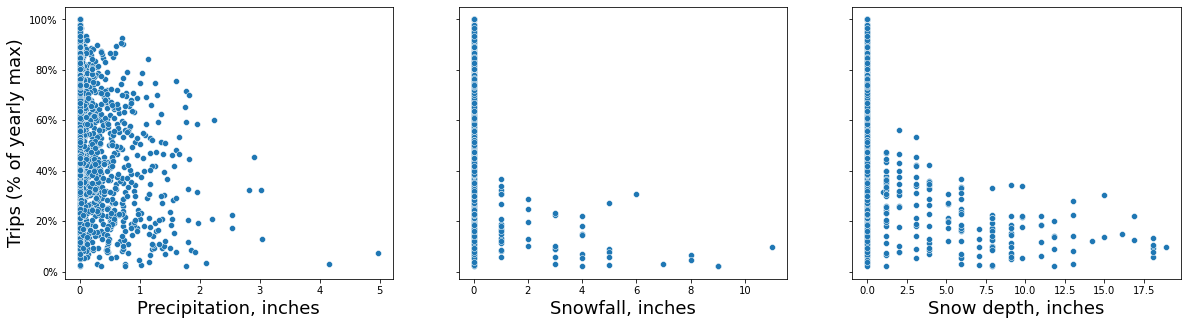

In [48]:
fig, axs = plt.subplots(1, 3, figsize=(20,5), sharey=True)

sns.scatterplot(x=df_nyc["PRCP"], y=df_nyc["count_mean"], ax=axs[0])
axs[0].set_xlabel('Precipitation, inches', fontsize=18)
axs[0].set_ylabel('Trips (% of yearly max)', fontsize=18)
axs[0].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))

sns.scatterplot(x=df_nyc["SNOW"], y=df_nyc["count_mean"], ax=axs[1])
axs[1].set_xlabel('Snowfall, inches', fontsize=18)

sns.scatterplot(x=df_nyc["SNWD"], y=df_nyc["count_mean"], ax=axs[2])
axs[2].set_xlabel('Snow depth, inches', fontsize=18)
pass

Ridership increases with temperature until the hottest days when it drops a bit.  
Ridership drops significantly on days when there is at least some precipitation or snow.

#### Prediction with weather

In [50]:
df_nyc["PRCP_log"] = np.log(df_nyc["PRCP"] + 1)
df_nyc["SNOW_log"] = np.log(df_nyc["SNOW"] + 1)
df_nyc["SNWD_log"] = np.log(df_nyc["SNWD"] + 1)

In [68]:
weather_features = ["TMAX", "TMIN", "PRCP_log", "SNOW_log", "SNWD_log"]
wt_columns = ["WT01", "WT08"]
features = [*calendar_features, *weather_features]

df_train, df_test, y_test, y_train, regr = fit_predict(df_nyc, features, model="ridge", degree=2, alphas=np.logspace(1,3,20))

Best alpha: 42.81332398719393
Training set R2 score: 0.9327849766454881
Test set R2 core: 0.8682394796881155
Test set MAPE: 13.83693165082033


In [52]:
plot_test(df_test,
          y_test,
          "Actual and predicted number of trips in 2019<br>Polynomial regression with regularization using calendar and weather features")

In [53]:
plot_dow_month(df_test,
               y_test,
               title="Actual and predicted number of daily trips in 2019")

### Number of bikes and stations

Citi Bike finally began operations on May 27, 2013, with 332 stations  
Officials said the system opened with 6,000 bikes  
The system expanded across the Hudson River to Jersey City, New Jersey, on September 21, 2015, with 35 stations and 350 bikes  
In July 2016, the Jersey City Citi Bike system was expanded for the first time, with another 15 stations and an additional 150 bikes.  
In August 2016, the company started installing 139 new stations  
140 new stalls and 2,000 new bikes in Harlem, Crown Heights, Prospect Heights, Long Island City, and Astoria were installed in September 2017  
706 stations and 12,000 bikes as of October 2017  
Citi Bike is the nation's largest bike share program, with 14,500 bikes and 950 stations (now) or 15,000 bikes and over 1,000 stations.



Use snapshots of home page

|Date|Number of bikes|Number of stations|Neightborhoods|
|---|---|---|---|
|   |   |   |   |
|   |   |   |   |
|   |   |   |   |
|   |10000|600|55|
|2017-11-20|12000|750|60|
|   |   |   |   |

Read monthly reports  

After the January 21
snow event, NYCBS began reducing overall fleet size to the 70% allowed under the contract for
winter operations. The full reduction to 70% will be achieved in February.

In [54]:
df_bikes_stations = pd.read_csv("data/nyc/bikes_stations.csv", parse_dates=["Month"])
df_bikes_stations["Year"] = pd.DatetimeIndex(df_bikes_stations["Month"]).year
df_bikes_stations["Month"] = pd.DatetimeIndex(df_bikes_stations["Month"]).month
df_bikes_stations.head()

,Month,Stations,Target bikes,Avg active bikes,EoM fleet,Membership,Unnamed: 6,Year
0,6,322,NaN,5130.0,6000.0,52130.0,NaN,2013
1,7,328,NaN,5531.0,6000.0,66315.0,NaN,2013
2,8,332,NaN,5681.0,6000.0,77138.0,NaN,2013
3,9,332,NaN,5513.0,6000.0,85241.0,NaN,2013
4,10,332,NaN,5623.0,6000.0,93124.0,NaN,2013


In [55]:
df_nyc = df_nyc.merge(df_bikes_stations, on=["Year", "Month"], how="left")
df_nyc.head()

,date,count,Year,Month,Week,Day,Day of Week,Day of Year,sin_doy,cos_doy,sin_dow,cos_dow,dow_0,dow_1,dow_2,dow_3,dow_4,dow_5,dow_6,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,day_1,day_2,day_3,day_4,day_5,day_6,day_7,day_8,day_9,day_10,day_11,day_12,day_13,day_14,day_15,day_16,day_17,day_18,day_19,day_20,day_21,day_22,day_23,day_24,day_25,day_26,day_27,day_28,day_29,day_30,day_31,holiday,DATE,AWND,PRCP,SNOW,SNWD,TMAX,TMIN,WDF2,WDF5,WSF2,WSF5,WT01,WT02,WT03,WT04,WT06,WT08,countmax,count_mean,PRCP_log,SNOW_log,SNWD_log,Stations,Target bikes,Avg active bikes,EoM fleet,Membership,Unnamed: 6
0,2013-06-01,8722,2013,6,22,1,5,152,0.501242,-0.865307,-0.974928,-0.222521,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2013-06-01,3.80,0.00,0,0.0,90,73,250,260,12.1,19.9,0,0,0,0,0,0,41383,0.210763,0.000000,0.0,0.0,322,NaN,5130.0,6000.0,52130.0,NaN
1,2013-06-02,15971,2013,6,22,2,6,153,0.486273,-0.873807,-0.781831,0.623490,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2013-06-02,6.04,0.85,0,0.0,88,69,250,270,15,25.9,1,0,0,0,0,0,41383,0.385931,0.615186,0.0,0.0,322,NaN,5130.0,6000.0,52130.0,NaN
2,2013-06-03,7598,2013,6,23,3,0,154,0.471160,-0.882048,0.000000,1.000000,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2013-06-03,3.36,0.87,0,0.0,78,66,250,250,12.1,19,1,0,0,0,0,0,41383,0.183602,0.625938,0.0,0.0,322,NaN,5130.0,6000.0,52130.0,NaN
3,2013-06-04,15782,2013,6,23,4,1,155,0.455907,-0.890028,0.781831,0.623490,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2013-06-04,4.92,0.00,0,0.0,75,57,10,340,13,21,0,0,0,0,0,0,41383,0.381364,0.000000,0.0,0.0,322,NaN,5130.0,6000.0,52130.0,NaN
4,2013-06-05,15690,2013,6,23,5,2,156,0.440519,-0.897743,0.974928,-0.222521,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2013-06-05,3.80,0.00,0,0.0,74,58,160,210,10.1,19,0,0,0,0,0,0,41383,0.379141,0.000000,0.0,0.0,322,NaN,5130.0,6000.0,52130.0,NaN


In [56]:
# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter(x=df_nyc["date"], y=df_nyc["Stations"], name="Stations"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=df_nyc["date"], y=df_nyc["Avg active bikes"], name="Average active bikes"),
    secondary_y=True,
)

# Add figure title
fig.update_layout(
    title_text="Monthly number of stations and bikes",
    legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=0.01
    )
)

# Set y-axes titles
fig.update_yaxes(title_text="Stations", secondary_y=False)
fig.update_yaxes(title_text="Bikes", secondary_y=True)

fig.show()

In [57]:
features = [*calendar_features, *weather_features, "EoM fleet"]
df_train, df_test, y_test, y_train, regr = fit_predict(df_nyc, features, model="ridge", alphas=np.logspace(1,2))

Best alpha: 21.209508879201906
Training set R2 score: 0.9509990041292177
Test set R2 core: 0.8579832554908067
Test set MAPE: 15.117064190806124


In [58]:
plot_test(df_test,
          y_test,
          "Actual and predicted number of trips in 2019<br>Polynomial regression with regularization using calendar, weather and system size features")

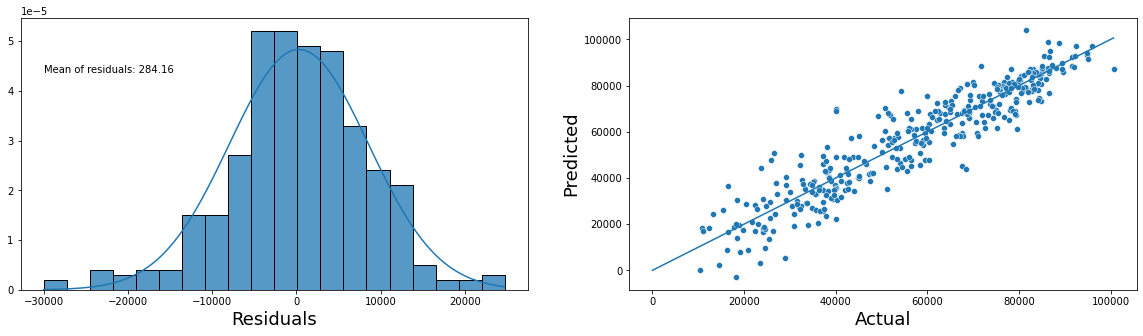

In [59]:
plot_model_evaluation(df_test, y_test)

In [60]:
plot_dow_month(df_test,
               y_test,
               title="Actual and predicted number of daily trips in 2019")

### Prediction 2020

In [61]:
df = df_nyc.copy()
df = df[df["Stations"].notna()]
features = [*calendar_features, *weather_features, "Stations"]

df_train_2020, df_test_2020, y_test_2020, y_train_2020, regr_2020 = fit_predict(df, features, model="ridge", degree=2, alphas=np.logspace(0,2,20), train_year_to=2019, test_year=2020)

Best alpha: 4.281332398719393
Training set R2 score: 0.9558876321218833
Test set R2 core: 0.30619026519327663
Test set MAPE: 44.554335634697765


In [62]:
df_nyc.tail()

,date,count,Year,Month,Week,Day,Day of Week,Day of Year,sin_doy,cos_doy,sin_dow,cos_dow,dow_0,dow_1,dow_2,dow_3,dow_4,dow_5,dow_6,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,day_1,day_2,day_3,day_4,day_5,day_6,day_7,day_8,day_9,day_10,day_11,day_12,day_13,day_14,day_15,day_16,day_17,day_18,day_19,day_20,day_21,day_22,day_23,day_24,day_25,day_26,day_27,day_28,day_29,day_30,day_31,holiday,DATE,AWND,PRCP,SNOW,SNWD,TMAX,TMIN,WDF2,WDF5,WSF2,WSF5,WT01,WT02,WT03,WT04,WT06,WT08,countmax,count_mean,PRCP_log,SNOW_log,SNWD_log,Stations,Target bikes,Avg active bikes,EoM fleet,Membership,Unnamed: 6
2727,2020-11-26,31215,2020,11,48,26,3,331,-0.565345,0.824855,0.433884,-0.900969,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,2020-11-26,4.70,0.79,0,0.0,65,55,270,270,13,19.9,1,0,0,0,0,0,103403,0.301877,0.582216,0.0,0.0,1081,NaN,NaN,NaN,NaN,NaN
2728,2020-11-27,53848,2020,11,48,27,4,332,-0.551102,0.834438,-0.433884,-0.900969,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,2020-11-27,3.36,0.00,0,0.0,63,51,290,270,8.9,14.1,0,0,0,0,0,0,103403,0.520759,0.000000,0.0,0.0,1081,NaN,NaN,NaN,NaN,NaN
2729,2020-11-28,53896,2020,11,48,28,5,333,-0.536696,0.843776,-0.974928,-0.222521,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,2020-11-28,4.92,0.00,0,0.0,56,44,280,10,14.1,21.9,0,0,0,0,0,0,103403,0.521223,0.000000,0.0,0.0,1081,NaN,NaN,NaN,NaN,NaN
2730,2020-11-29,53239,2020,11,48,29,6,334,-0.522133,0.852864,-0.781831,0.623490,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,2020-11-29,2.24,0.00,0,0.0,54,41,230,200,8.9,14.1,0,0,0,0,0,0,103403,0.514869,0.000000,0.0,0.0,1081,NaN,NaN,NaN,NaN,NaN
2731,2020-11-30,23528,2020,11,49,30,0,335,-0.507415,0.861702,0.000000,1.000000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,2020-11-30,6.26,0.98,0,0.0,63,50,170,200,19.9,35.1,1,0,0,0,0,0,103403,0.227537,0.683097,0.0,0.0,1081,NaN,NaN,NaN,NaN,NaN


In [63]:
plot_dow_month(df_test_2020, y_test_2020)

Statewide stay-at-home order issued on 22.03.   
Phase 1 reopening 08.06   
Phase 2 reopening 22.06  
Phase 3 reopening 06.07  
Phase 4 reopening 20.07

In [64]:
fig = plot_test(df_test_2020,
                y_test_2020,
                comparison=df_nyc[df_nyc["Year"] == 2019]["count"].values, 
                comparison_title=2019, 
                show=False,
                scatter=False,
                title="Actual and predicted number of daily trips in 2020 with 2019 for comparison")

fig.add_vrect(
    x0="2020-03-22", x1="2020-06-08",
    fillcolor="LightSalmon", opacity=0.5,
    layer="below", line_width=0,
    annotation_text="Stay-at-home order",
    annotation_position="top left"
)

fig.add_vrect(
    x0="2020-06-08", x1="2020-07-20",
    fillcolor="LightGreen", opacity=0.5,
    layer="below", line_width=0,
    annotation_text="Reopening",
    annotation_position="top left"
)

fig.show()

In [65]:
df = df_test_2020[df_test_2020["Month"] > 7].copy()
comparison = df_nyc.query("Year == 2019 & Month > 7")["count"].values
plot_dow_month(
    df,
    y_test_2020[-len(df.index):],
    comparison=comparison,
    comparison_title="2019",
    title="Actual and predicted number of daily trips in 2020 with 2019 for comparison")